In [1]:
import datetime, time, sys, os, math, random, copy

In [2]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import cufflinks as cf
import seaborn as sns

import pydotplus
from IPython.display import Image

In [3]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.externals import joblib

In [4]:
import pyspark.sql as spark
from pyspark.sql import SQLContext, HiveContext, Column, Row
from pyspark.sql import DataFrame as DFSpark
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Data and Model

In [5]:
hiveCtx = HiveContext(sc)

In [6]:
# get data from hive
start_time = str(time.mktime(time.strptime('20170101', '%Y%m%d')))
end_time = str(time.mktime(time.strptime('20170301', '%Y%m%d')))
sql = """
SELECT application_id,
       salary,
       gender,
       amount,
       amount_per_installment,
       age,
       edu_level_ordered,
       work_unit_city_level,
       zmxy_score,
       scorecf,
       indextransbehavior_businesstrip
FROM income_prediction_project.tmp_features_20160101_20170301
WHERE UNIX_TIMESTAMP(applied_at, 'yyyy-MM-dd HH:mm:ss') >= %s
  AND UNIX_TIMESTAMP(applied_at, 'yyyy-MM-dd HH:mm:ss') < %s
  AND state IN ('disbursed', 'closed')
  AND salary > 500
  AND salary < 15000
""" % (start_time, end_time)

data = hiveCtx.sql(sql).toPandas()
data.count()['application_id']

57238

In [7]:
X_regression = [
    'amount', 'amount_per_installment', 'age', 'edu_level_ordered', 'work_unit_city_level',  
    'zmxy_score', 'scorecf', 'indextransbehavior_businesstrip'    
]
y_regression = 'salary'

In [8]:
# 回归模型，使用gbdt
model_regression = GradientBoostingRegressor(loss = 'ls',
                                    learning_rate = 0.02,
                                    n_estimators = 200,
                                    subsample = 0.8, 
                                    max_features = 0.8, 
                                    min_samples_split = 200,
                                    min_samples_leaf = 200,
                                    max_depth = 6,
                                    verbose = 3)

model_regression.fit(data[X_regression].as_matrix(), data[y_regression].as_matrix())

      Iter       Train Loss      OOB Improve   Remaining Time 
         1     5433470.7278       29930.1557           13.76s
         2     5416795.3870       28874.9218           13.80s
         3     5396727.6024       27828.0332           13.91s
         4     5373884.1978       26009.7107           13.66s
         5     5334576.1936       26185.2305           13.63s
         6     5273180.9716       25801.3237           13.58s
         7     5265505.1817       24644.9854           13.56s
         8     5235861.2212       23230.7263           13.53s
         9     5231472.4255       22083.8748           13.53s
        10     5194036.4939       20376.7434           13.45s
        11     5196514.3857       20791.1703           13.43s
        12     5165789.3898       19459.0179           13.36s
        13     5126025.5714       18734.8319           13.26s
        14     5123334.6462       18659.2029           13.18s
        15     5093463.3607       17866.0240           13.08s
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='ls', max_depth=6, max_features=0.8,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=200, min_samples_split=200,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=0.8, verbose=3,
             warm_start=False)

In [9]:
# 分类问题，使用scikit-learn自带的iris数据
iris_data = load_iris(return_X_y = True)
X_classification = iris_data[0]
y_classification = iris_data[1]

In [10]:
# 分类模型，简单的决策树
model_classification = tree.DecisionTreeClassifier()
model_classification.fit(X_classification, y_classification)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

# Demo

### 通用模型分析方法

In [11]:
# 初始化模型分析实例
from model_analysis import ModelAnalysis
ma_reg = ModelAnalysis(m_type = 'regression', m_model = 'gbdt')
ma_clf = ModelAnalysis(m_type = 'classification', m_model = 'tree')

/disk1/soft/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



/disk1/soft/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans



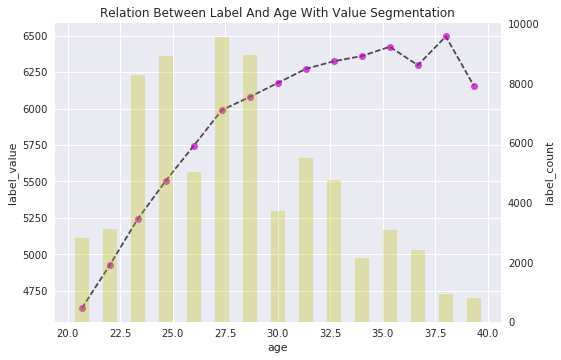

In [12]:
# 标签与特征的关系 - regression - 按值分段
ma_reg.label_feature_relation_plotter(
    data['age'].as_matrix(),   # 需要研究的特征
    data['salary'].as_matrix(),   # 对应的标签
    'age',   # 特征名称
    seg = 'value',   # 分段方法
    bin = 15   # 分段段数
)
plt.show()

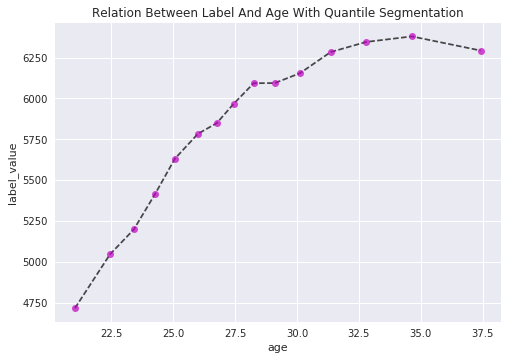

In [13]:
# 标签与特征的关系 - regression - 按百分位分段
ma_reg.label_feature_relation_plotter(
    data['age'].as_matrix(),   # 需要研究的特征
    data['salary'].as_matrix(),   # 对应的标签
    'age',   # 特征名称
    seg = 'quantile',   # 分段方法
    bin = 15   # 分段段数
)
plt.show()

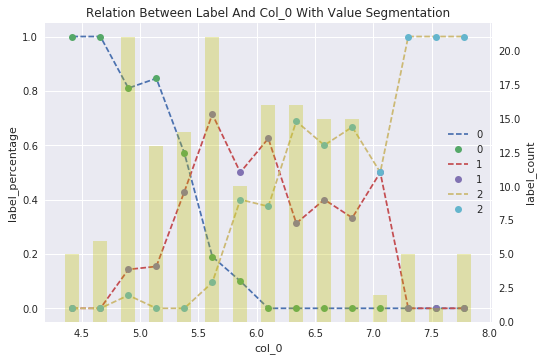

In [14]:
# 标签与特征的关系 - classification - 按值分段
ma_clf.label_feature_relation_plotter(
    X_classification[:, 0],   # 需要研究的特征
    y_classification,   # 对应的标签
    'col_0',   # 特征名称
    seg = 'value',   # 分段方法
    bin = 15   # 分段段数
)
plt.show()

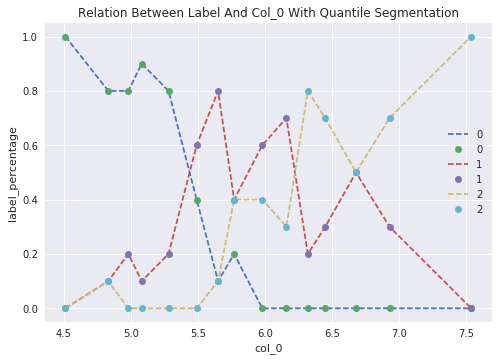

In [15]:
# 标签与特征的关系 - classification - 按百分位分段
ma_clf.label_feature_relation_plotter(
    X_classification[:, 0],   # 需要研究的特征
    y_classification,   # 对应的标签
    'col_0',   # 特征名称
    seg = 'quantile',   # 分段方法
    bin = 15   # 分段段数
)
plt.show()

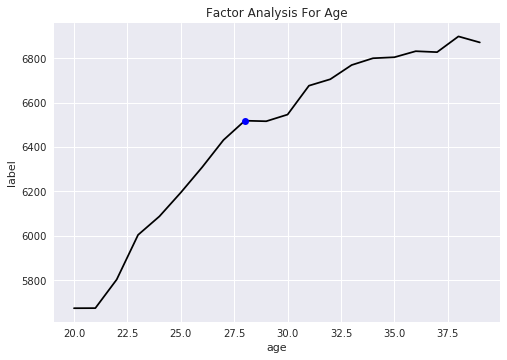

In [16]:
# 因素分析 - regression
sample_X = data[X_regression][0 : 1].as_matrix()[0]
"""sample_X
array([  3.00000000e+04,   3.25800000e+03,   2.80000000e+01,
         3.00000000e+00,   8.00000000e+00,   5.79000000e+02,
         6.89000000e+02,  -1.00000000e+00])
"""
ma_reg.factor_analysis_plotter(
    "sklearn.ensemble",   # 模型属于的包
    "GradientBoostingRegressor",   # 模型所属的类
    model_regression,   # 模型
    sample_X,   # 样本特征向量
    2,   # 需要观察的特征的index
    'age',   # 特征名称
    np.arange(20, 40, 1)  # 所选特征变化范围
)
plt.show()

In [17]:
# 基于特征移除的分析 - regression
samples_X = data[X_regression][0 : 10]   # 选取10个样本
removal = ma_reg.feature_removal_predict(
    "sklearn.ensemble",   # 模型属于的包
    "GradientBoostingRegressor",   # 模型所属的类
    model_regression,   # 模型
    samples_X,   # 选取的样本（多个）
    [0, 2],   # 需要移除的特征index，这里移除了amount和age
    [-1, -1]   # 移除特征对应的default值
)
print "original salary: "
print data['salary'][0 : 10].as_matrix()
print "original prediction: "
print model_regression.predict(samples_X)
print "removal prediction: "
print removal

original salary: 
[4500 5000 6000 8000 3000 2500 4500 3200 6000 8000]
original prediction: 
[ 6518.57361147  5157.89582128  4940.81113912  5420.61275178  5421.42217319
  4699.02296678  5311.94846024  6024.85759218  5322.08253537  6398.12695733]
removal prediction: 
[ 5770.87630176  5029.5045464   4950.74041863  5363.63041229  4545.85159005
  4578.78323216  5209.26244958  5413.7955963   4910.27937747  5618.37314507]


### 树模型分析方法

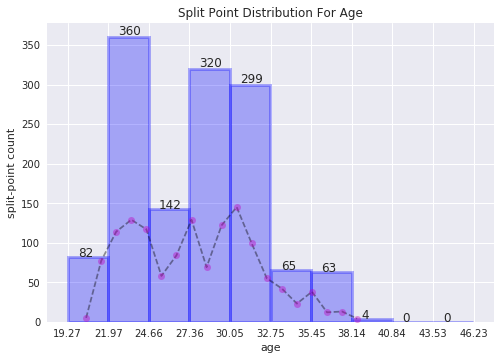

In [18]:
# 特征分裂点分布 - gbdt
splits_points_reg = ma_reg.tree_splits_points(model_regression)   # 获取所有特征的所有分裂点
ma_reg.split_point_plotter(
    splits_points_reg[2],   # 第2个特征的所有分裂点（age）
    'age',   # 特征名称
    fs_min = None,   # 自定义特征值域最小值，可为None
    fs_max = 45,   # 自定义特征值域最大值，可为None
    bin = 10   # 分段段数
)
plt.show()

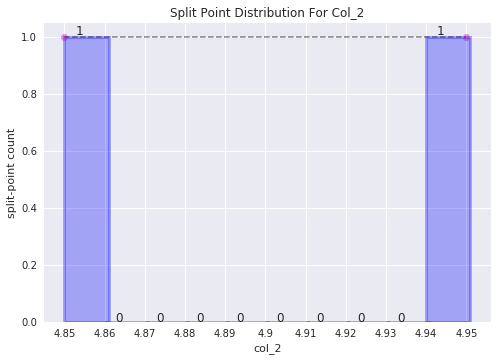

In [19]:
# 特征分裂点分布 - tree
splits_points_clf = ma_clf.tree_splits_points(model_classification)   # 获取所有特征的所有分裂点
ma_clf.split_point_plotter(
    splits_points_clf[2],   # 第2个特征的所有分裂点（age）
    'col_2',   # 特征名称
    fs_min = None,   # 自定义特征值域最小值，可为None
    fs_max = None,   # 自定义特征值域最大值，可为None
    bin = 10   # 分段段数
)
plt.show()

In [20]:
# 训练阶段的特征重要性 - gbdt
ma_reg.feature_importances_train_stage("sklearn.ensemble", "GradientBoostingRegressor", model_regression)

array([ 0.0722483 ,  0.17387821,  0.18572489,  0.08564575,  0.19660892,
        0.14553087,  0.11220156,  0.02816149])

In [21]:
# 训练阶段的特征重要性 - tree
ma_clf.feature_importances_train_stage("sklearn.tree.tree", "DecisionTreeClassifier", model_classification)

array([ 0.01333333,  0.01333333,  0.05072262,  0.92261071])

In [22]:
# 预测阶段的特征重要性 - gdbt with 'ls' loss - 取每次分裂变化的绝对值
ma_reg.feature_importances_predict_stage(
    model_regression,   # 模型
    sample_X   # 选取一个样本，见因素分析demo
)

array([ 0.05079031,  0.19199011,  0.15215255,  0.18513289,  0.19786022,
        0.04949154,  0.16662627,  0.00595611])

### GBDT模型分析方法

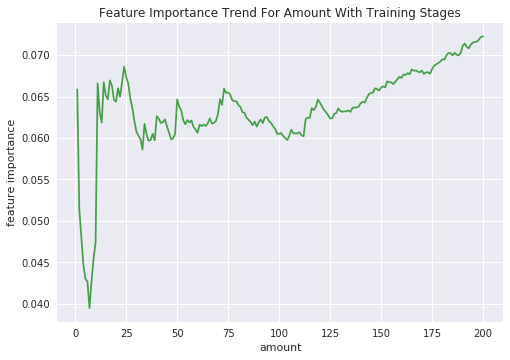

In [23]:
# 特征学习的充分性 - gbdt
inter_fi = ma_reg.inter_feature_importances(model_regression)   # 计算gbdt模型每次迭代后的特征重要性
ma_reg.feature_importance_trend_plotter(
    inter_fi, # gbdt模型每次迭代后的特征重要性  
    0,   # 所选特征在模型中的index
    'amount'  # 特征名称
)
plt.show()

### xgboost模型分析方法

In [24]:
# 用分类模型做xgboost模型分析演示，也可用于回归
import xgboost as xgb
from model_analysis import ModelAnalysis
model_xgb_clf = xgb.XGBClassifier(n_estimators = 50)
model_xgb_clf.fit(X_classification, y_classification)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [25]:
# 定义模型分析器
ma_xgboost_clf = ModelAnalysis(m_type = 'classification', m_model = 'xgboost')

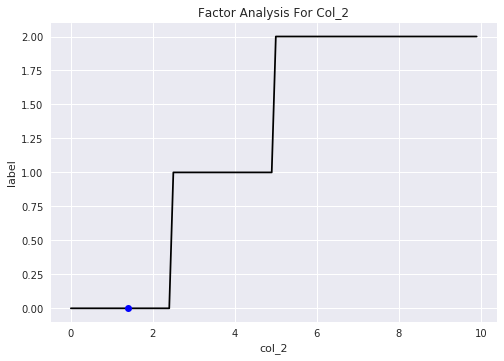

In [26]:
# 因素分析 - classification - xgboost
sample_X = X_classification[0]
"""sample_X
array([ 5.1,  3.5,  1.4,  0.2])
"""
ma_xgboost_clf.factor_analysis_plotter(
    "xgboost",   # 模型属于的包
    "XGBClassifier",   # 模型所属的类
    model_xgb_clf,   # 模型
    sample_X,   # 样本特征向量
    2,   # 需要观察的特征的index
    'col_2',   # 特征名称
    np.arange(0, 10, 0.1)  # 所选特征变化范围
)
plt.show()

In [27]:
# 基于特征移除的分析 - classification - xgboost
samples_X = X_classification[90 : 110]   # 选取20个样本
removal = ma_xgboost_clf.feature_removal_predict(
    "xgboost",   # 模型属于的包
    "XGBClassifier",   # 模型所属的类
    model_xgb_clf,   # 模型
    samples_X,   # 选取的样本（多个）
    [2],   # 需要移除的特征index
    [-1]   # 移除特征对应的default值
)
print "original label: "
print y_classification[90 : 110]
print "original prediction: "
print model_xgb_clf.predict(samples_X)
print "removal prediction: "
print removal

original label: 
[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
original prediction: 
[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
removal prediction: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


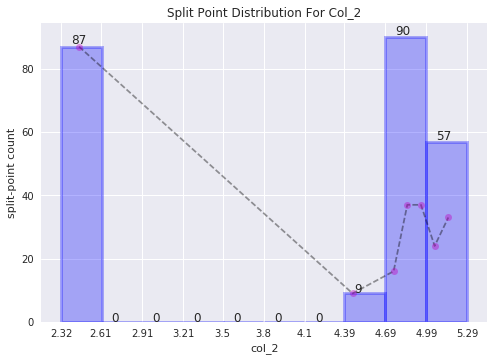

In [28]:
# 特征分裂点分布 - classification - xgboost
splits_points_xgboost_clf = ma_xgboost_clf.tree_splits_points(model_xgb_clf)   # 获取所有特征的所有分裂点
ma_xgboost_clf.split_point_plotter(
    splits_points_xgboost_clf[2],   # 第2个特征的所有分裂点
    'col_2',   # 特征名称
    fs_min = None,   # 自定义特征值域最小值，可为None
    fs_max = None,   # 自定义特征值域最大值，可为None
    bin = 10   # 分段段数
)
plt.show()

In [29]:
# 训练阶段的特征重要性 - classification - xgboost
ma_xgboost_clf.feature_importances_train_stage("xgboost", "XGBClassifier", model_xgb_clf)

array([ 0.03469591,  0.0454907 ,  0.68186511,  0.23794828])

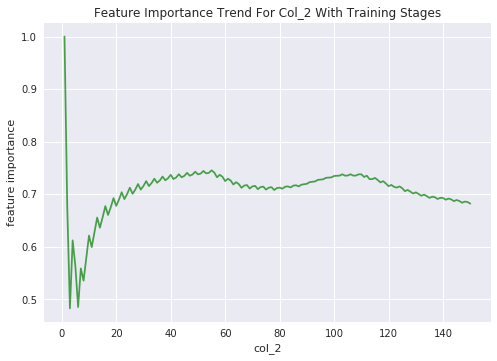

In [30]:
# 特征学习的充分性 - classification - xgboost
inter_fi = ma_xgboost_clf.inter_feature_importances(model_xgb_clf)   # 计算gbdt模型每次迭代后的特征重要性
ma_xgboost_clf.feature_importance_trend_plotter(
    inter_fi, # xxgboost模型每次迭代后的特征重要性  
    2,   # 所选特征在模型中的index
    'col_2'  # 特征名称
)
plt.show()

### RF模型分析方法

In [31]:
# 用分类/回归模型做随机森林模型分析演示，也可用于回归
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from model_analysis import ModelAnalysis

In [32]:
# 分类模型 - RF
model_rf_clf = RandomForestClassifier(n_estimators = 50)
model_rf_clf.fit(X_classification, y_classification)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [33]:
# 回归模型 - RF
model_rf_reg = RandomForestRegressor(n_estimators = 50)
model_rf_reg.fit(data[X_regression].as_matrix(), data[y_regression].as_matrix())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [34]:
# 定义模型分析器
ma_rf_reg = ModelAnalysis(m_type = 'regression', m_model = 'rf')
ma_rf_clf = ModelAnalysis(m_type = 'classification', m_model = 'rf')

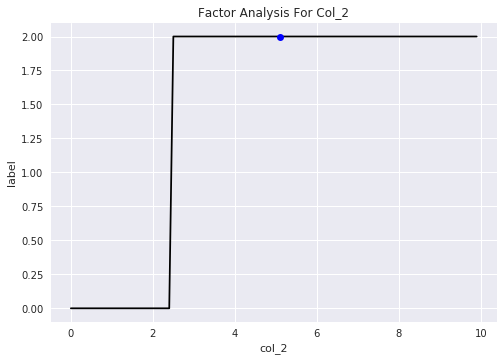

In [35]:
# 因素分析 - classification - rf
sample_X = X_classification[101]
"""sample_X
array([ 5.1,  3.5,  1.4,  0.2])
"""
ma_rf_clf.factor_analysis_plotter(
    "sklearn.ensemble",   # 模型属于的包
    "RandomForestClassifier",   # 模型所属的类
    model_rf_clf,   # 模型
    sample_X,   # 样本特征向量
    2,   # 需要观察的特征的index
    'col_2',   # 特征名称
    np.arange(0, 10, 0.1)  # 所选特征变化范围
)
plt.show()

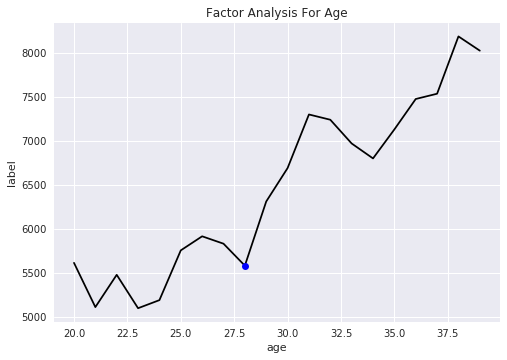

In [36]:
# 因素分析 - regressionclassification - rf
sample_X = data[X_regression][0 : 1].as_matrix()[0]
"""sample_X
array([  3.00000000e+04,   3.25800000e+03,   2.80000000e+01,
         3.00000000e+00,   8.00000000e+00,   5.79000000e+02,
         6.89000000e+02,  -1.00000000e+00])
"""
ma_rf_clf.factor_analysis_plotter(
    "sklearn.ensemble",   # 模型属于的包
    "RandomForestRegressor",   # 模型所属的类
    model_rf_reg,   # 模型
    sample_X,   # 样本特征向量
    2,   # 需要观察的特征的index
    'age',   # 特征名称
    np.arange(20, 40, 1)  # 所选特征变化范围
)
plt.show()

In [37]:
# 基于特征移除的分析 - classification - rf
samples_X = X_classification[90 : 110]   # 选取20个样本
removal = ma_rf_clf.feature_removal_predict(
    "sklearn.ensemble",   # 模型属于的包
    "RandomForestClassifier",   # 模型所属的类
    model_rf_clf,   # 模型
    samples_X,   # 选取的样本（多个）
    [2],   # 需要移除的特征index
    [-1]   # 移除特征对应的default值
)
print "original label: "
print y_classification[90 : 110]
print "original prediction: "
print model_rf_clf.predict(samples_X)
print "removal prediction: "
print removal

original label: 
[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
original prediction: 
[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
removal prediction: 
[1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0]


In [38]:
# 基于特征移除的分析 - regression - rf
samples_X = data[X_regression][0 : 20]   # 选取20个样本
removal = ma_rf_reg.feature_removal_predict(
    "sklearn.ensemble",   # 模型属于的包
    "RandomForestRegressor",   # 模型所属的类
    model_rf_reg,   # 模型
    samples_X,   # 选取的样本（多个）
    [2, 3],   # 需要移除的特征index
    [-1, -1]   # 移除特征对应的default值
)
print "original label: "
print data[y_regression][0 : 20].as_matrix()
print "original prediction: "
print model_rf_reg.predict(samples_X)
print "removal prediction: "
print removal

original label: 
[ 4500  5000  6000  8000  3000  2500  4500  3200  6000  8000  6000  8000
  8000  6000  7000  4000 10000  3800  6000  6000]
original prediction: 
[ 5580.          5406.57142857  5756.          6388.          5169.          3860.
  4798.          3998.          5793.56        7590.          5691.2
  6931.6         6562.          6496.          5562.          4211.9         8130.
  4758.          5810.          5476.        ]
removal prediction: 
[ 5612.          4352.66666667  5756.          5390.          4328.          4270.
  4994.36        5820.24        5630.          6220.          4188.          4264.
  4385.          6386.          4290.8         3857.81666667  5078.18
  4392.          5428.          4164.        ]


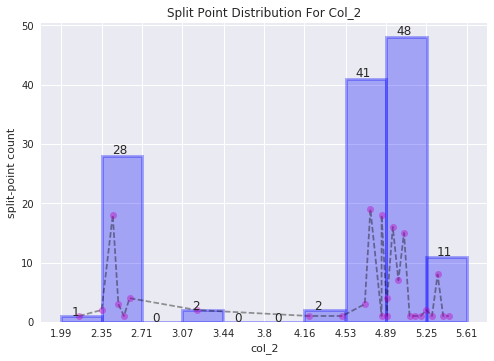

In [39]:
# 特征分裂点分布 - classification - rf
splits_points_rf_clf = ma_rf_clf.tree_splits_points(model_rf_clf)   # 获取所有特征的所有分裂点
ma_rf_clf.split_point_plotter(
    splits_points_rf_clf[2],   # 第2个特征的所有分裂点
    'col_2',   # 特征名称
    fs_min = None,   # 自定义特征值域最小值，可为None
    fs_max = None,   # 自定义特征值域最大值，可为None
    bin = 10   # 分段段数
)
plt.show()

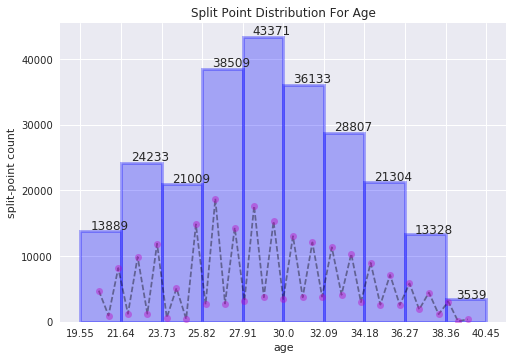

In [40]:
# 特征分裂点分布 - regression - rf
splits_points_rf_reg = ma_rf_reg.tree_splits_points(model_rf_reg)   # 获取所有特征的所有分裂点
ma_rf_reg.split_point_plotter(
    splits_points_rf_reg[2],   # 第2个特征的所有分裂点
    'age',   # 特征名称
    fs_min = None,   # 自定义特征值域最小值，可为None
    fs_max = None,   # 自定义特征值域最大值，可为None
    bin = 10   # 分段段数
)
plt.show()

In [41]:
# 训练阶段的特征重要性 - classification - rf
ma_rf_clf.feature_importances_train_stage("sklearn.ensemble", "RandomForestClassifier", model_rf_clf)

array([ 0.126146  ,  0.03147944,  0.42340312,  0.41897143])

In [42]:
# 训练阶段的特征重要性 - regression - rf
ma_rf_reg.feature_importances_train_stage("sklearn.ensemble", "RandomForestRegressor", model_rf_reg)

array([ 0.057829  ,  0.12846088,  0.16678669,  0.06126505,  0.07172774,
        0.33007271,  0.14999299,  0.03386492])

In [43]:
# 测试阶段的特征重要性 - classification - rf
# 对于分类问题，每个类别的特征重要性单独计算了，即分裂前后节点预测概率之差。
sample_X = X_classification[0]
ma_rf_clf.feature_importances_predict_stage(
    model_rf_clf,   # 模型
    sample_X   # 选取一个样本，见因素分析demo
)

array([[ 0.20837415,  0.00963509,  0.39208055,  0.38991021],
       [ 0.15392696,  0.0163601 ,  0.44335053,  0.38636241],
       [ 0.26106125,  0.00230291,  0.35206523,  0.38457061]])

In [44]:
# 测试阶段的特征重要性 - regression - rf
sample_X = data[X_regression][0 : 1].as_matrix()[0]
ma_rf_reg.feature_importances_predict_stage(
    model_rf_reg,   # 模型
    sample_X   # 选取一个样本，见因素分析demo
)

array([ 0.02880604,  0.08320436,  0.16711144,  0.07410816,  0.08308605,
        0.22552412,  0.30628756,  0.03187226])

### Add some features for plotting -- 2017.03.20
+ 因素分析对比：可指定线条和点的格式
+ 特征分裂点对比：可指定线条、点、直方条的格式
+ 特征学习充分性对比：可指定线条格式
+ 特征分裂点：加入value参数，当value='rel'时，计算分裂点个数的相对值（归一化）；当value='abs'或默认时，计算分裂点个数绝对值。
+ 设置图的大小：在调用方法前指定一下plt.subplots(1, 1, figsize=(width, height))等

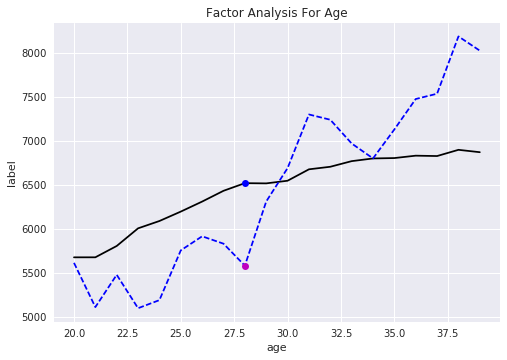

In [45]:
# 因素分析对比 -- 可指定线条和点的颜色
sample_X = data[X_regression][0 : 1].as_matrix()[0]
"""sample_X
array([  3.00000000e+04,   3.25800000e+03,   2.80000000e+01,
         3.00000000e+00,   8.00000000e+00,   5.79000000e+02,
         6.89000000e+02,  -1.00000000e+00])
"""

# gbdt
ma_reg.factor_analysis_plotter(
    "sklearn.ensemble",   # 模型属于的包
    "GradientBoostingRegressor",   # 模型所属的类
    model_regression,   # 模型
    sample_X,   # 样本特征向量
    2,   # 需要观察的特征的index
    'age',   # 特征名称
    np.arange(20, 40, 1),  # 所选特征变化范围
    line_format = 'k',  # 线条格式
    dot_format = 'bo'  # 点格式
)

# rf
ma_rf_clf.factor_analysis_plotter(
    "sklearn.ensemble",   # 模型属于的包
    "RandomForestRegressor",   # 模型所属的类
    model_rf_reg,   # 模型
    sample_X,   # 样本特征向量
    2,   # 需要观察的特征的index
    'age',   # 特征名称
    np.arange(20, 40, 1),  # 所选特征变化范围
    line_format = 'b--',  # 线条格式
    dot_format = 'mo'  # 点格式
)

plt.show()

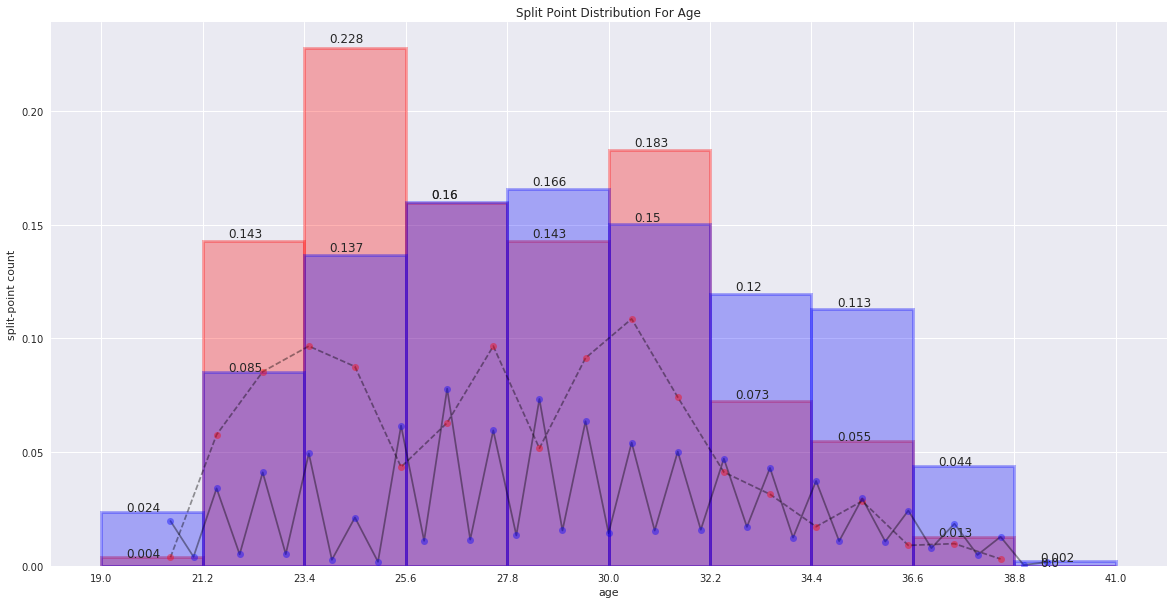

In [46]:
# 特征分裂点对比 -- 可指定直方条、线条和点的颜色
# 可指定参数value为rel来计算特征数量的相对值（value默认为abs，输出为特征数量的绝对值）

# 可在这里指定作图大小
plt.subplots(1, 1, figsize=(20, 10))

# gbdt
splits_points_reg = ma_reg.tree_splits_points(model_regression)   # 获取所有特征的所有分裂点
ma_reg.split_point_plotter(
    splits_points_reg[2],   # 第2个特征的所有分裂点（age）
    'age',   # 特征名称
    fs_min = 20,   # 自定义特征值域最小值，可为None
    fs_max = 40,   # 自定义特征值域最大值，可为None
    bin = 10,   # 分段段数
    value = 'rel',  # 分裂次数的相对值
    bar_format = 'r',  # 直方条格式与颜色
    line_format = 'k--',  # 线条格式与颜色
    dot_format = 'ro'  # 点的格式与颜色
)

# rf
splits_points_rf_reg = ma_rf_reg.tree_splits_points(model_rf_reg)   # 获取所有特征的所有分裂点
ma_rf_reg.split_point_plotter(
    splits_points_rf_reg[2],   # 第2个特征的所有分裂点
    'age',   # 特征名称
    fs_min = 20,   # 自定义特征值域最小值，可为None
    fs_max = 40,   # 自定义特征值域最大值，可为None
    bin = 10,   # 分段段数
    value = 'rel',  # 分裂次数的相对值
    bar_format = 'b',  # 直方条格式与颜色
    line_format = 'k',  # 线条格式与颜色
    dot_format = 'bo'  # 点的格式与颜色
)

plt.show()

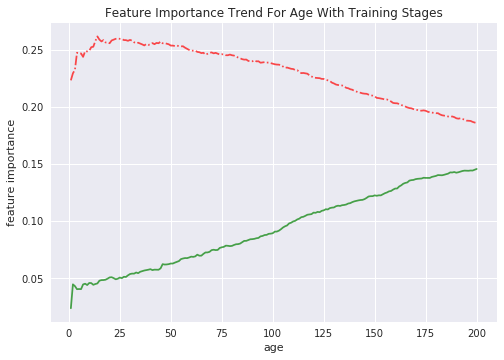

In [47]:
# 特征学习充分性对比 -- 可指定线条格式

# xgboost - zmxy_scor
inter_fi = ma_reg.inter_feature_importances(model_regression)   # 计算gbdt模型每次迭代后的特征重要性
ma_reg.feature_importance_trend_plotter(
    inter_fi, # gbdt模型每次迭代后的特征重要性  
    5,   # 所选特征在模型中的index
    'zmxy_score',   # 特征名称
    line_format = 'g'  # 线条格式与颜色
)

# xgboost - age
ma_reg.feature_importance_trend_plotter(
    inter_fi, # gbdt模型每次迭代后的特征重要性  
    2,   # 所选特征在模型中的index
    'age',  # 特征名称
    line_format = 'r-.'  # 线条格式与颜色
)

plt.show()

### modify on feature importance of predicting stage -- 2017.03.21
+ 添加决策树的预测阶段的特征重要性方法
+ 对所有预测阶段的特征重要性方法，添加参数change。默认change='abs',即计算预测阶段特征重要性时，对分裂前后带来的变化的“绝对值”进行累加，这种计算方法下所有特征重要性均为0-1之间的实数。若指定change=None，则按之前的方法计算，即直接对分裂前后带来的变化值进行累加。

In [48]:
# 预测阶段的特征重要性方法 - tree - 使用变化的绝对值进行累加
sample_X = X_classification[90]
"""sample_X
array([ 5.1,  3.5,  1.4,  0.2])
"""

ma_clf.feature_importances_predict_stage(
    model_classification,   # 模型
    sample_X   # 选取一个样本，见因素分析demo
)

array([[ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.10763889,  0.89236111],
       [ 0.        ,  0.        ,  0.10763889,  0.89236111]])

In [49]:
# 测阶段的特征重要性方法 - tree - 使用变化的原始值进行累加
ma_clf.feature_importances_predict_stage(
    model_classification,   # 模型
    sample_X,   # 选取一个样本，见因素分析demo
    change = None   # 使用变化的原始值进行累加
)

array([[-0.        , -0.        , -0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.10763889,  0.89236111],
       [-0.        , -0.        ,  0.21527778,  0.78472222]])